In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import networkx as nx
%matplotlib inline
from shapely.geometry import Point, Polygon
from geopy.distance import geodesic
import geopy.distance
from sklearn.neighbors import DistanceMetric
import math
from math import radians

In [2]:
!pip install osmnx

In [3]:
!pip install matplotlib==3.1.3

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [499 lines of output]
  Edit setup.cfg to change the build options
  
  BUILDING MATPLOTLIB
    matplotlib: yes [3.1.3]
        python: yes [3.10.4 | packaged by conda-forge | (main, Mar 24 2022,
                    17:34:17) [MSC v.1929 64 bit (AMD64)]]
      platform: yes [win32]
  
  OPTIONAL SUBPACKAGES
   sample_data: yes [installing]
         tests: no  [skipping due to configuration]
  
  OPTIONAL BACKEND EXTENSIONS
           agg: yes [installing]
         tkagg: yes [installing; run-time loading from Python Tcl/Tk]
        macosx: no  [Mac OS-X only]
  
  OPTIONAL PACKAGE DATA
          dlls: no  [skipping due to configuration]
  
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-310
  copying lib\pylab.py -> build\lib.win-amd64-cpython-310
  creating build\lib.win-amd64-cpython-310\matplotlib
  copy

  Using cached matplotlib-3.1.3.tar.gz (40.9 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for matplotlib
Failed to build matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.5.3
    Uninstalling matplotlib-3.5.3:
      Successfully uninstalled matplotlib-3.5.3
  Running setup.py install for matplotlib: started
  Running setup.py install for matplotlib: finished with status 'error'
  Rolling back uninstall of matplotlib
  Moving to c:\users\yasam\appdata\roaming\python\python310\site-packages\__pycache__\pylab.cpython-310.pyc
   from C:\Users\yasam\AppData\Local\Temp\pip-uninstall-1kvod8ic\pylab.cpython-310.pyc
  Moving to c:\users\yasam\appdata\roaming\python\python310\site-packages\matplotlib-3.5.3-py3.10-nspkg.pth
   from C:\Users\yasam\AppData\Local\Temp\pip-uninstall-1q97qz9e\matplotlib-3.5.3-py3.10-nspkg.pth
  Moving to c:\users\yasam\appdata\roaming\python\


# Estimate centrality measure for a tree
Important: 

for plotting osmnx we need to use matplotlib specific version. We install it above.

For estimating centrality for a tree, first we find a closest node in city network to each tree and calculate everything for that node. 

Algorithm for estimating centrality:

1. Load a graph G of a city as diGraph(simple graph without any multigraph info) from the initial multigraph of a city 

2. Load coordinates of a tree

3. Find closest node for a tree in a digraph

4. Estimate centrality for node found in 3. for a tree


### 1. Load a graph G of a city as diGraph(simple graph without any multigraph info) from the initial multigraph of a city 

In [4]:
import osmnx as ox

# load city graph as Multigraph
place_name = 'Rome, Italy'  # Fetch OSM street network from the location
graphcity = ox.graph_from_place(place_name)# Get place boundary related to the place name as a geodataframe
print('done with loading city graph')

done with loading city graph


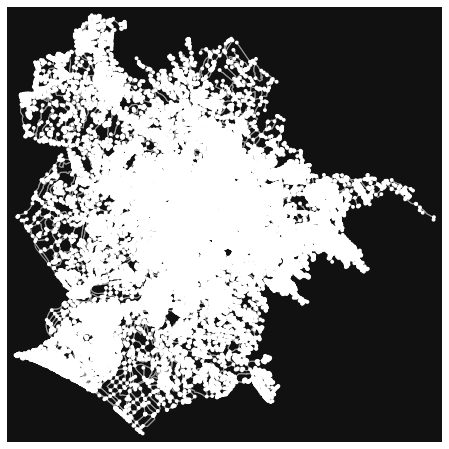

In [5]:
# Plot the streets graph
area = ox.geocode_to_gdf(place_name)
fig, ax = ox.plot_graph(graphcity, dpi = 500)

In [6]:
#save G graph into file 
print(type(graphcity))
nx.write_edgelist(graphcity, "edgescity.csv", delimiter=" ") # edges with attributes!!!
edges = graphcity.edges.data()  # default data is {} (empty dict)

#print((edges))
print(type(edges))


# we save graph as a shapefile, if you prefer obsolete formats
ox.save_graph_geopackage(graphcity, filepath="graph_city.gpkg")

# save/load graph as a graphml file: this is the best way to save your model
filepath = "graph_city.graphml"
ox.save_graphml(graphcity, filepath)


<class 'networkx.classes.multidigraph.MultiDiGraph'>
<class 'networkx.classes.reportviews.OutMultiEdgeDataView'>


### 2. Load coordinates of a tree


In [45]:
# Opening the dataset, cleaning and adding needed columns. For now we use only 0.01 of the whole data.

tr = pd.read_csv('/content/New_punti_with_lon_lat.csv', index_col = False)
tr["lat-lon"] = list(zip(tr['lat'], tr['lon']))
tr.rename(columns={'Unnamed: 0': 'treeID'}, inplace=True)
#tr.reset_index(drop=True, inplace=True)
tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410974 entries, 0 to 410973
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   treeID      410974 non-null  int64  
 1   DESCRIZION  408148 non-null  object 
 2   MUNICIPIO   410974 non-null  float64
 3   CODICE_COM  410974 non-null  int64  
 4   CODICE_PRO  410974 non-null  int64  
 5   SCALA_NOMI  410974 non-null  int64  
 6   DATA        410974 non-null  object 
 7   CARTA       410974 non-null  int64  
 8   DITTA       410974 non-null  float64
 9   FLAG_LIM    66499 non-null   float64
 10  IDENTIFICA  410974 non-null  float64
 11  CODICE      410974 non-null  object 
 12  CODICE_DGC  248485 non-null  float64
 13  geometry    410974 non-null  object 
 14  lon         410974 non-null  float64
 15  lat         410974 non-null  float64
 16  lat-lon     410974 non-null  object 
dtypes: float64(7), int64(5), object(5)
memory usage: 53.3+ MB


In [48]:
tr_point_zero_one = tr.sample(frac=0.01)
tr_point_zero_one.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4110 entries, 344142 to 96529
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   treeID      4110 non-null   int64  
 1   DESCRIZION  4078 non-null   object 
 2   MUNICIPIO   4110 non-null   float64
 3   CODICE_COM  4110 non-null   int64  
 4   CODICE_PRO  4110 non-null   int64  
 5   SCALA_NOMI  4110 non-null   int64  
 6   DATA        4110 non-null   object 
 7   CARTA       4110 non-null   int64  
 8   DITTA       4110 non-null   float64
 9   FLAG_LIM    665 non-null    float64
 10  IDENTIFICA  4110 non-null   float64
 11  CODICE      4110 non-null   object 
 12  CODICE_DGC  2451 non-null   float64
 13  geometry    4110 non-null   object 
 14  lon         4110 non-null   float64
 15  lat         4110 non-null   float64
 16  lat-lon     4110 non-null   object 
dtypes: float64(7), int64(5), object(5)
memory usage: 578.0+ KB


### 3. Find closest node for a tree in a digraph


In [9]:
# load a graph G for a city as digraph by converting MultiDigraph into DiGraph 
digraph = nx.DiGraph(graphcity)



# load coordinates of a tree
center_point = list(tr['lat-lon']) # we don't use it now
X = list(tr_point_zero_one['lon'])
Y = list(tr_point_zero_one['lat'])


# Find closest node in a city graph to each tree position 
center_node = []
for i in range(len(X)):
    if i % 100 == 0: # to see how it is going. It takes a long time.
        print(i)  
    center_node.append(ox.distance.nearest_nodes(graphcity, X[i], Y[i]))
    
# So in center_node we will hace a list of nodes, closest to each tree in ourdataset. So we can add it as a new column.
tr_point_zero_one["node"] = center_node

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100


In [10]:
# Taking all nodes and edges in our network graph

nodeslist = digraph.nodes() #All of the nodes in our graph. All the nodes that we have. 
edgeslist = digraph.edges() # load all edges of a graph G

In [50]:
tr_point_zero_one.head()

,treeID,DESCRIZION,MUNICIPIO,CODICE_COM,CODICE_PRO,SCALA_NOMI,DATA,CARTA,DITTA,FLAG_LIM,IDENTIFICA,CODICE,CODICE_DGC,geometry,lon,lat,lat-lon,node
344142,344142,Albero isolato,12.0,91,58,5000,16/05/02,374153,100.0,NaN,4.000000e+11,030101S,6657.0,POINT (12.508564214133449 41.82240669867468),12.508564,41.822407,"(41.82240669867468, 12.508564214133449)",6053215291
232071,232071,Albero isolato,4.0,91,58,5000,23/04/02,374034,100.0,0.0,4.000000e+11,030101S,NaN,POINT (12.512036731785088 41.98673563943297),12.512037,41.986736,"(41.98673563943297, 12.512036731785088)",1541394608
302474,302474,Albero isolato in area urbana,11.0,91,58,5000,25/04/02,374141,100.0,NaN,4.000000e+11,030108,14299.0,POINT (12.484872727897946 41.83372095095645),12.484873,41.833721,"(41.83372095095645, 12.484872727897946)",1445283603
301538,301538,Albero isolato in area urbana,11.0,91,58,5000,25/04/02,374141,100.0,NaN,4.000000e+11,030108,9474.0,POINT (12.488981660874003 41.83196457493331),12.488982,41.831965,"(41.83196457493331, 12.488981660874003)",6389505827
400282,400282,Albero isolato in area urbana,13.0,91,58,5000,23/04/02,387054,100.0,NaN,4.000000e+11,030108,37004.0,POINT (12.37321274738774 41.73933988042096),12.373213,41.739340,"(41.73933988042096, 12.37321274738774)",6380416262


### 4. Estimate centrality for node closest to each tree (found in step 3)


In [12]:
betweenn_tree = nx.betweenness_centrality_subset(digraph, center_node, nodeslist)

In [13]:
# So we have centrality of each node 
btwn_list = []
for i, row in tr_point_zero_one.iterrows():
    for el in betweenn_tree.keys():
        if tr_point_zero_one['node'][i] == el:
            btwn_list.append(betweenn_tree[el])

In [51]:
tr_point_zero_one['btwn_centrality'] = btwn_list

In [52]:
tr_point_zero_one.columns

Index(['treeID', 'DESCRIZION', 'MUNICIPIO', 'CODICE_COM', 'CODICE_PRO',
       'SCALA_NOMI', 'DATA', 'CARTA', 'DITTA', 'FLAG_LIM', 'IDENTIFICA',
       'CODICE', 'CODICE_DGC', 'geometry', 'lon', 'lat', 'lat-lon', 'node',
       'btwn_centrality'],
      dtype='object')

### Estimating the degree centrality
We estimate the degree centrality for all nodes in the graph and then among them, we find the nodes in our dataset (found in step 3). So in our degree_list we have degree centrality for our nodes and we pass it to our dataset. 

In [16]:
degree_cent = nx.degree_centrality(digraph)

In [17]:
degree_list = []
for i, row in tr_point_zero_one.iterrows():
    for el in degree_cent.keys():
        if tr_point_zero_one['node'][i] == el:
            degree_list.append(degree_cent[el])

In [117]:
tr_point_zero_one['degree_centrality'] = degree_list

In [54]:
tr_point_zero_one.head()

,treeID,DESCRIZION,MUNICIPIO,CODICE_COM,CODICE_PRO,SCALA_NOMI,DATA,CARTA,DITTA,FLAG_LIM,IDENTIFICA,CODICE,CODICE_DGC,geometry,lon,lat,lat-lon,node,btwn_centrality,degree_centrality
344142,344142,Albero isolato,12.0,91,58,5000,16/05/02,374153,100.0,NaN,4.000000e+11,030101S,6657.0,POINT (12.508564214133449 41.82240669867468),12.508564,41.822407,"(41.82240669867468, 12.508564214133449)",6053215291,8186.000000,0.000049
232071,232071,Albero isolato,4.0,91,58,5000,23/04/02,374034,100.0,0.0,4.000000e+11,030101S,NaN,POINT (12.512036731785088 41.98673563943297),12.512037,41.986736,"(41.98673563943297, 12.512036731785088)",1541394608,0.000000,0.000033
302474,302474,Albero isolato in area urbana,11.0,91,58,5000,25/04/02,374141,100.0,NaN,4.000000e+11,030108,14299.0,POINT (12.484872727897946 41.83372095095645),12.484873,41.833721,"(41.83372095095645, 12.484872727897946)",1445283603,82438.833012,0.000049
301538,301538,Albero isolato in area urbana,11.0,91,58,5000,25/04/02,374141,100.0,NaN,4.000000e+11,030108,9474.0,POINT (12.488981660874003 41.83196457493331),12.488982,41.831965,"(41.83196457493331, 12.488981660874003)",6389505827,0.000000,0.000016
400282,400282,Albero isolato in area urbana,13.0,91,58,5000,23/04/02,387054,100.0,NaN,4.000000e+11,030108,37004.0,POINT (12.37321274738774 41.73933988042096),12.373213,41.739340,"(41.73933988042096, 12.37321274738774)",6380416262,0.000000,0.000016


## Plotting some graphs

In [55]:
tr_btwn_no_zero = tr_point_zero_one[tr_point_zero_one['btwn_centrality'] > 0]
tr_btwn_no_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2771 entries, 344142 to 316372
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   treeID             2771 non-null   int64  
 1   DESCRIZION         2752 non-null   object 
 2   MUNICIPIO          2771 non-null   float64
 3   CODICE_COM         2771 non-null   int64  
 4   CODICE_PRO         2771 non-null   int64  
 5   SCALA_NOMI         2771 non-null   int64  
 6   DATA               2771 non-null   object 
 7   CARTA              2771 non-null   int64  
 8   DITTA              2771 non-null   float64
 9   FLAG_LIM           428 non-null    float64
 10  IDENTIFICA         2771 non-null   float64
 11  CODICE             2771 non-null   object 
 12  CODICE_DGC         1670 non-null   float64
 13  geometry           2771 non-null   object 
 14  lon                2771 non-null   float64
 15  lat                2771 non-null   float64
 16  lat-lon          

In [56]:
cent_group = tr_point_zero_one.groupby('btwn_centrality')['treeID'].count()
cent_group = cent_group.reset_index().sort_values(by = 'treeID', ascending = False)
cent_group

,btwn_centrality,treeID
0,0.000000e+00,1339
270,8.186000e+03,74
144,4.093000e+03,48
448,1.637200e+04,16
269,8.184000e+03,12
...,...,...
820,6.032712e+04,1
819,6.023715e+04,1
818,5.996679e+04,1
817,5.965972e+04,1


In [58]:
cent_group_no_zero = tr_btwn_no_zero.groupby('btwn_centrality')['treeID'].count()
cent_group_no_zero = cent_group_no_zero.reset_index().sort_values(by = 'treeID', ascending = False)
cent_group_no_zero

,btwn_centrality,treeID
269,8.186000e+03,74
143,4.093000e+03,48
447,1.637200e+04,16
268,8.184000e+03,12
1115,1.292890e+05,11
...,...,...
799,5.599402e+04,1
798,5.589166e+04,1
797,5.555813e+04,1
796,5.524457e+04,1


C:\Users\yasam\anaconda31\envs\geo_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\yasam\AppData\Local\Temp\ipykernel_14100\3813971140.py:5: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0)


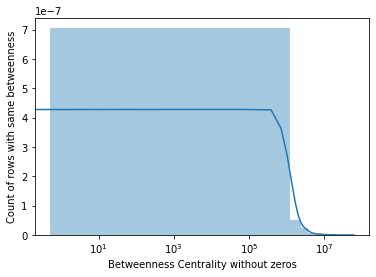

In [65]:
ax = sns.distplot(x=cent_group_no_zero["btwn_centrality"])
ax.set_xlabel("‌Betweenness Centrality without zeros", fontsize = 10)
ax.set_ylabel("Count of rows with same betweenness", fontsize = 10)
ax.set_xscale('log')
plt.xlim(0)
plt.savefig('betwenness_count_displot_log_scale.png', dpi = 300,bbox_inches="tight")
plt.show()

C:\Users\yasam\anaconda31\envs\geo_env\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


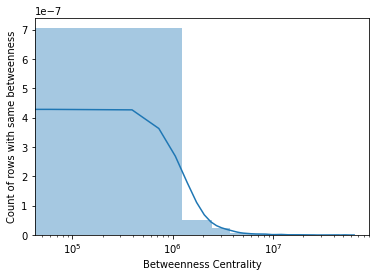

In [69]:
ax = sns.distplot(x=cent_group["btwn_centrality"])
ax.set_xlabel("‌Betweenness Centrality", fontsize = 10)
ax.set_ylabel("Count of rows with same betweenness", fontsize = 10)

ax.set_xscale('log')

plt.savefig('betwenness_count_displot_lgscale.png', dpi = 300,bbox_inches="tight")
plt.show()

C:\Users\yasam\AppData\Local\Temp\ipykernel_14100\1467181676.py:3: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0)


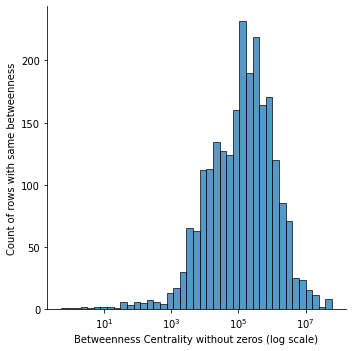

In [95]:
ax = sns.displot(x="btwn_centrality", data=cent_group_no_zero, log_scale = True)
ax.set_axis_labels('Betweenness Centrality without zeros (log scale)', 'Count of rows with same betweenness')
plt.xlim(0)
plt.savefig('betwenness_count_displot_logscale.png', dpi = 300,bbox_inches="tight")
plt.show()

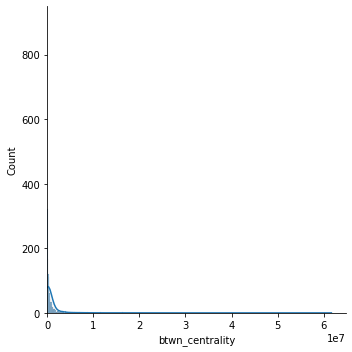

In [75]:
ax = sns.displot(cent_group["btwn_centrality"], kde=True)
plt.xlim(0)
#plt.savefig('betwennness_cent_count_histplot_logscale.png', dpi = 300,bbox_inches="tight")
plt.show()

C:\Users\yasam\AppData\Local\Temp\ipykernel_14100\1370498666.py:4: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0)


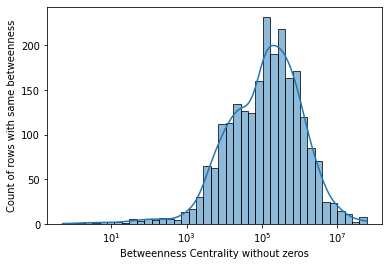

In [77]:
ax = sns.histplot(cent_group_no_zero["btwn_centrality"], kde=True, log_scale = True)
ax.set_xlabel('Betweenness Centrality without zeros', fontsize = 10)
ax.set_ylabel("Count of rows with same betweenness", fontsize = 10)
plt.xlim(0)
plt.savefig('betwennness_cent_count_no_zero_histplot_logscale.png', dpi = 300)
plt.show()

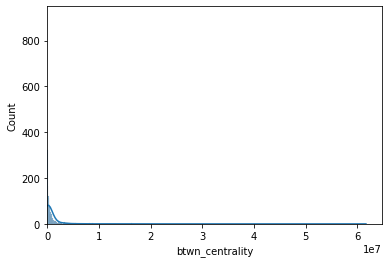

In [79]:
ax = sns.histplot(cent_group["btwn_centrality"], kde=True)
plt.xlim(0)
#plt.savefig('betwennness_cent_count_histplot.png', dpi = 300)
plt.show()

In [97]:
degree_group = tr_point_zero_one.groupby('degree_centrality')['treeID'].count()
degree_group = degree_group.reset_index().sort_values(by = 'treeID', ascending = False)
degree_group

,degree_centrality,treeID
5,4.95,1591
1,1.65,1283
3,3.30,552
2,2.47,317
4,4.12,211
7,6.60,113
6,5.77,40
8,8.24,2
0,0.82,1


In [124]:
tr_point_zero_one['degree_centrality'] = tr_point_zero_one['degree_centrality'] * (10 ** 5)

In [125]:
tr_point_zero_one['degree_centrality'] = tr_point_zero_one['degree_centrality'].round(decimals = 2)

In [126]:
tr_point_zero_one['degree_centrality'].unique()

array([4.95, 3.3 , 1.65, 6.6 , 4.12, 2.47, 5.77, 0.82, 8.24])

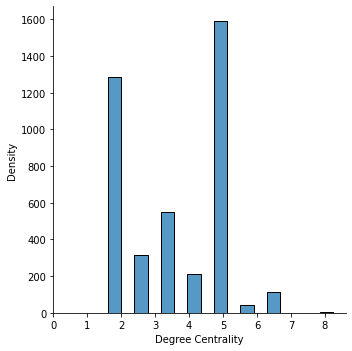

In [129]:
ax = sns.displot(tr_point_zero_one['degree_centrality'])
ax.set_axis_labels('Degree Centrality', 'Density')
plt.xlim(0)
#plt.savefig('Degree centrality distribution.png', dpi = 300)
plt.show()

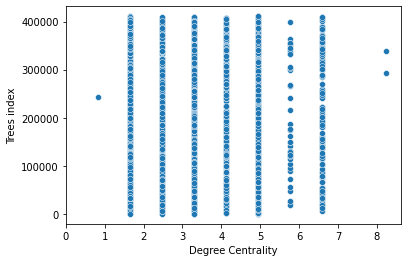

In [128]:
ax = sns.scatterplot(x = tr_point_zero_one['degree_centrality'], y = tr_point_zero_one['treeID'])
ax.set_xlabel('Degree Centrality', fontsize = 10)
ax.set_ylabel("Trees index", fontsize = 10)
plt.xlim(0)
plt.savefig('sctterplot of degree and treeid.png', dpi = 300)
plt.show()

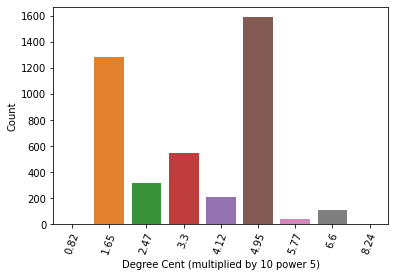

In [135]:
ax = sns.countplot(x = tr_point_zero_one['degree_centrality'])#, y = tr_point_zero_one['lon'])
ax.set_xlabel('Degree Cent (multiplied by 10 power 5)', fontsize = 10)
ax.set_ylabel("Count", fontsize = 10)
plt.xticks(rotation=70)

plt.savefig('countplot_degree_treeId.png', dpi = 300, bbox_inches="tight")
plt.show()

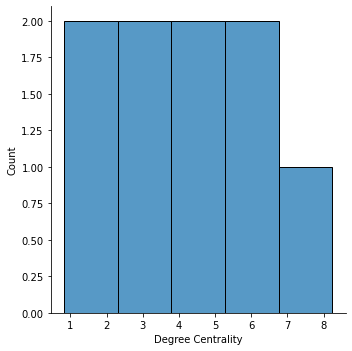

In [145]:
ax = sns.displot(x="degree_centrality", data=degree_group)#, log_scale = True)
ax.set_axis_labels('Degree Centrality', 'Count')
plt.savefig('Distribution of degree centrality displot.png', dpi = 300, bbox_inches="tight")
plt.show()

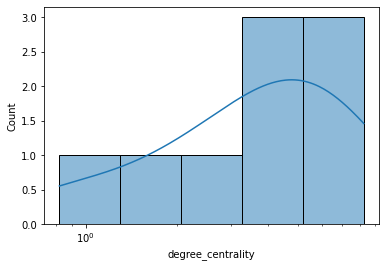

In [146]:
ax = sns.histplot(degree_group["degree_centrality"], kde=True, log_scale = True)
plt.savefig('Distribution of degree centrality histogram.png', dpi = 300, bbox_inches="tight")
plt.show()